In [1]:
# !pip install catboost

In [21]:
from pyforest import *
import seaborn as sns

from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
df = pd.read_csv('heart.csv')
df

<IPython.core.display.Javascript object>

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## Train-Test Split:

In [4]:
from sklearn.model_selection import train_test_split

#spliting the df
y = df['output']
x = df.drop('output', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=1)

## Scaler

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                        Neural Network": MLPClassifier(),
    "                         Random Forest": RandomForestClassifier(),
    "                     Gradient Boosting": GradientBoostingClassifier(),
    "                               XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "                              LightGBM": LGBMClassifier(),
    "                              CatBoost": CatBoostClassifier(verbose=0)
}

for name, model in models.items():
    model.fit(scaled_X_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                        Neural Network trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.
                              LightGBM trained.
                              CatBoost trained.


In [7]:
for name, model in models.items():
    test_preds = model.predict(scaled_X_test)
    train_preds = model.predict(scaled_X_train)
    print('-------------------------------------------------------------------')
    print(name + ": {:.2f}%".format(model.score(X_test, y_test) * 100))
    print('Training Precision: ', precision_score(y_train, train_preds, average='macro'))
    print('Testing Precision: ', precision_score(y_test, test_preds, average='macro'))
    print('Training Recall: ', recall_score(y_train, train_preds, average='macro'))
    print('Testing Recall: ', recall_score(y_test, test_preds, average='macro'))
    print('Training Accuracy: ', accuracy_score(y_train, train_preds))
    print('Testing Accuracy: ', accuracy_score(y_test, test_preds))
    print('Training F1-Score: ', f1_score(y_train, train_preds, average='macro'))
    print('Testing F1-Score: ', f1_score(y_test, test_preds, average='macro'))     

-------------------------------------------------------------------
                   Logistic Regression: 57.38%
Training Precision:  0.8684173669467787
Testing Precision:  0.7417582417582418
Training Recall:  0.8635295743504698
Testing Recall:  0.7365591397849462
Training Accuracy:  0.8677685950413223
Testing Accuracy:  0.7377049180327869
Training F1-Score:  0.8654153632255822
Testing F1-Score:  0.7359307359307359
-------------------------------------------------------------------
                   K-Nearest Neighbors: 50.82%
Training Precision:  0.8805964936788433
Testing Precision:  0.7565359477124183
Training Recall:  0.8765201768933112
Testing Recall:  0.7532258064516129
Training Accuracy:  0.8801652892561983
Testing Accuracy:  0.7540983606557377
Training F1-Score:  0.8781660677395274
Testing F1-Score:  0.7530364372469636
-------------------------------------------------------------------
                         Decision Tree: 32.79%
Training Precision:  1.0
Testing Precision:

## Gridsearch

In [29]:
#Running GridSearch to find the most optimal 
clf = CatBoostClassifier()
parameters = {
    'learning_rate': [0.005, 0.01, 0.02, 0.3],  
    'depth': [2, 3, 4, 5, 6],  
    'objective': ['RMSE', 'QuerySoftMax', 'Logloss', 'Accuracy'],
    'eval_metric': ['RMSE', 'Precision', 'Recall', 'Accuracy'],
    'leaf_estimation_method': ['Newton', 'Gradient', 'Exact'],
    'leaf_estimation_iterations': [2, 3, 4,]} 

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="accuracy",
                    cv=5,
                    verbose=2)
#                     return_train_score=True)

grid.fit(scaled_X_train, y_train)

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
0:	learn: 0.8402778	total: 1.12ms	remaining: 1.11s
1:	learn: 0.8551724	total: 2.19ms	remaining: 1.09s
2:	learn: 0.8671329	total: 3.21ms	remaining: 1.07s
3:	learn: 0.8620690	total: 4.23ms	remaining: 1.05s
4:	learn: 0.8551724	total: 5.17ms	remaining: 1.03s
5:	learn: 0.8661972	total: 6.21ms	remaining: 1.03s
6:	learn: 0.8551724	total: 7.12ms	remaining: 1.01s
7:	learn: 0.8551724	total: 8.05ms	remaining: 998ms
8:	learn: 0.8435374	total: 9.06ms	remaining: 998ms
9:	learn: 0.8551724	total: 10.1ms	remaining: 996ms
10:	learn: 0.8671329	total: 11.1ms	remaining: 997ms
11:	learn: 0.8680556	total: 12.1ms	remaining: 992ms
12:	learn: 0.8620690	total: 13ms	remaining: 988ms
13:	learn: 0.8689655	total: 13.9ms	remaining: 981ms
14:	learn: 0.8680556	total: 14.9ms	remaining: 978ms
15:	learn: 0.8680556	total: 15.8ms	remaining: 975ms
16:	learn: 0.8680556	total: 16.7ms	remaining: 967ms
17:	learn: 0.8680556	total: 17.8ms	remaining: 971ms
18:	learn:

309:	learn: 0.8827586	total: 299ms	remaining: 665ms
310:	learn: 0.8827586	total: 300ms	remaining: 664ms
311:	learn: 0.8888889	total: 301ms	remaining: 663ms
312:	learn: 0.8888889	total: 302ms	remaining: 662ms
313:	learn: 0.8888889	total: 302ms	remaining: 661ms
314:	learn: 0.8888889	total: 303ms	remaining: 659ms
315:	learn: 0.8888889	total: 304ms	remaining: 658ms
316:	learn: 0.8888889	total: 305ms	remaining: 657ms
317:	learn: 0.8888889	total: 306ms	remaining: 656ms
318:	learn: 0.8888889	total: 307ms	remaining: 655ms
319:	learn: 0.8888889	total: 308ms	remaining: 654ms
320:	learn: 0.8888889	total: 309ms	remaining: 653ms
321:	learn: 0.8827586	total: 310ms	remaining: 652ms
322:	learn: 0.8827586	total: 311ms	remaining: 651ms
323:	learn: 0.8827586	total: 312ms	remaining: 650ms
324:	learn: 0.8827586	total: 312ms	remaining: 649ms
325:	learn: 0.8827586	total: 313ms	remaining: 648ms
326:	learn: 0.8827586	total: 314ms	remaining: 647ms
327:	learn: 0.8827586	total: 315ms	remaining: 646ms
328:	learn: 

471:	learn: 0.8888889	total: 451ms	remaining: 504ms
472:	learn: 0.8888889	total: 452ms	remaining: 503ms
473:	learn: 0.8888889	total: 453ms	remaining: 502ms
474:	learn: 0.8888889	total: 454ms	remaining: 501ms
475:	learn: 0.8888889	total: 455ms	remaining: 501ms
476:	learn: 0.8888889	total: 456ms	remaining: 500ms
477:	learn: 0.8888889	total: 457ms	remaining: 499ms
478:	learn: 0.8888889	total: 458ms	remaining: 498ms
479:	learn: 0.8888889	total: 458ms	remaining: 497ms
480:	learn: 0.8888889	total: 459ms	remaining: 496ms
481:	learn: 0.8888889	total: 460ms	remaining: 495ms
482:	learn: 0.8888889	total: 461ms	remaining: 494ms
483:	learn: 0.8888889	total: 462ms	remaining: 493ms
484:	learn: 0.8888889	total: 463ms	remaining: 492ms
485:	learn: 0.8888889	total: 464ms	remaining: 491ms
486:	learn: 0.8888889	total: 465ms	remaining: 490ms
487:	learn: 0.8888889	total: 466ms	remaining: 489ms
488:	learn: 0.8888889	total: 467ms	remaining: 488ms
489:	learn: 0.8888889	total: 468ms	remaining: 487ms
490:	learn: 

632:	learn: 0.8951049	total: 603ms	remaining: 349ms
633:	learn: 0.8951049	total: 604ms	remaining: 348ms
634:	learn: 0.8951049	total: 604ms	remaining: 347ms
635:	learn: 0.8951049	total: 605ms	remaining: 347ms
636:	learn: 0.8951049	total: 606ms	remaining: 346ms
637:	learn: 0.8951049	total: 607ms	remaining: 344ms
638:	learn: 0.8951049	total: 608ms	remaining: 343ms
639:	learn: 0.8951049	total: 609ms	remaining: 343ms
640:	learn: 0.8951049	total: 610ms	remaining: 342ms
641:	learn: 0.8951049	total: 611ms	remaining: 341ms
642:	learn: 0.8951049	total: 612ms	remaining: 340ms
643:	learn: 0.8951049	total: 613ms	remaining: 339ms
644:	learn: 0.8951049	total: 614ms	remaining: 338ms
645:	learn: 0.8951049	total: 615ms	remaining: 337ms
646:	learn: 0.8951049	total: 616ms	remaining: 336ms
647:	learn: 0.8951049	total: 617ms	remaining: 335ms
648:	learn: 0.8951049	total: 618ms	remaining: 334ms
649:	learn: 0.8951049	total: 618ms	remaining: 333ms
650:	learn: 0.8951049	total: 619ms	remaining: 332ms
651:	learn: 

796:	learn: 0.9142857	total: 755ms	remaining: 192ms
797:	learn: 0.9142857	total: 756ms	remaining: 191ms
798:	learn: 0.9142857	total: 757ms	remaining: 190ms
799:	learn: 0.9142857	total: 758ms	remaining: 189ms
800:	learn: 0.9142857	total: 759ms	remaining: 188ms
801:	learn: 0.9142857	total: 760ms	remaining: 188ms
802:	learn: 0.9142857	total: 760ms	remaining: 187ms
803:	learn: 0.9142857	total: 762ms	remaining: 186ms
804:	learn: 0.9142857	total: 762ms	remaining: 185ms
805:	learn: 0.9142857	total: 763ms	remaining: 184ms
806:	learn: 0.9142857	total: 764ms	remaining: 183ms
807:	learn: 0.9142857	total: 765ms	remaining: 182ms
808:	learn: 0.9142857	total: 766ms	remaining: 181ms
809:	learn: 0.9142857	total: 767ms	remaining: 180ms
810:	learn: 0.9142857	total: 768ms	remaining: 179ms
811:	learn: 0.9142857	total: 769ms	remaining: 178ms
812:	learn: 0.9142857	total: 770ms	remaining: 177ms
813:	learn: 0.9142857	total: 771ms	remaining: 176ms
814:	learn: 0.9142857	total: 772ms	remaining: 175ms
815:	learn: 

958:	learn: 0.9148936	total: 907ms	remaining: 38.8ms
959:	learn: 0.9148936	total: 908ms	remaining: 37.8ms
960:	learn: 0.9148936	total: 909ms	remaining: 36.9ms
961:	learn: 0.9148936	total: 910ms	remaining: 35.9ms
962:	learn: 0.9148936	total: 911ms	remaining: 35ms
963:	learn: 0.9148936	total: 912ms	remaining: 34.1ms
964:	learn: 0.9148936	total: 913ms	remaining: 33.1ms
965:	learn: 0.9148936	total: 914ms	remaining: 32.2ms
966:	learn: 0.9148936	total: 915ms	remaining: 31.2ms
967:	learn: 0.9148936	total: 916ms	remaining: 30.3ms
968:	learn: 0.9148936	total: 917ms	remaining: 29.3ms
969:	learn: 0.9148936	total: 917ms	remaining: 28.4ms
970:	learn: 0.9148936	total: 918ms	remaining: 27.4ms
971:	learn: 0.9148936	total: 919ms	remaining: 26.5ms
972:	learn: 0.9148936	total: 920ms	remaining: 25.5ms
973:	learn: 0.9148936	total: 921ms	remaining: 24.6ms
974:	learn: 0.9148936	total: 922ms	remaining: 23.6ms
975:	learn: 0.9148936	total: 923ms	remaining: 22.7ms
976:	learn: 0.9148936	total: 924ms	remaining: 21

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020081F75240>,
             n_jobs=4,
             param_grid={'depth': [2, 3, 4, 5, 6],
                         'eval_metric': ['RMSE', 'Precision', 'Recall',
                                         'Accuracy'],
                         'leaf_estimation_iterations': [2, 3, 4],
                         'leaf_estimation_method': ['Newton', 'Gradient',
                                                    'Exact'],
                         'learning_rate': [0.005, 0.01, 0.02, 0.3],
                         'objective': ['RMSE', 'QuerySoftMax', 'Logloss',
                                       'Accuracy']},
             scoring='accuracy', verbose=2)

In [30]:
grid.best_params_

{'depth': 5,
 'eval_metric': 'Precision',
 'leaf_estimation_iterations': 2,
 'leaf_estimation_method': 'Gradient',
 'learning_rate': 0.005,
 'objective': 'Logloss'}

In [31]:
params_final = {'depth': 4,
 'eval_metric': 'Precision',
 'leaf_estimation_iterations': 2,
 'leaf_estimation_method': 'Gradient',
 'learning_rate': 0.005,
 'objective': 'Logloss'}

In [32]:
model2 = CatBoostClassifier(depth= 5,
 eval_metric ='Precision',
 leaf_estimation_iterations = 2,
 leaf_estimation_method = 'Gradient',
 learning_rate = 0.005,
 objective = 'Logloss')

model2.fit(scaled_X_train, y_train)

test_preds = model2.predict(scaled_X_test)
train_preds = model2.predict(scaled_X_train)

0:	learn: 0.8402778	total: 1.17ms	remaining: 1.17s
1:	learn: 0.8551724	total: 2.31ms	remaining: 1.15s
2:	learn: 0.8671329	total: 3.46ms	remaining: 1.15s
3:	learn: 0.8620690	total: 4.5ms	remaining: 1.12s
4:	learn: 0.8551724	total: 5.63ms	remaining: 1.12s
5:	learn: 0.8661972	total: 6.8ms	remaining: 1.13s
6:	learn: 0.8551724	total: 7.91ms	remaining: 1.12s
7:	learn: 0.8551724	total: 8.95ms	remaining: 1.11s
8:	learn: 0.8435374	total: 10.1ms	remaining: 1.11s
9:	learn: 0.8551724	total: 11.1ms	remaining: 1.09s
10:	learn: 0.8671329	total: 12.2ms	remaining: 1.09s
11:	learn: 0.8680556	total: 13.2ms	remaining: 1.09s
12:	learn: 0.8620690	total: 14.3ms	remaining: 1.09s
13:	learn: 0.8689655	total: 15.4ms	remaining: 1.08s
14:	learn: 0.8680556	total: 16.5ms	remaining: 1.08s
15:	learn: 0.8680556	total: 17.6ms	remaining: 1.08s
16:	learn: 0.8680556	total: 18.8ms	remaining: 1.09s
17:	learn: 0.8680556	total: 19.8ms	remaining: 1.08s
18:	learn: 0.8680556	total: 21ms	remaining: 1.08s
19:	learn: 0.8620690	total

316:	learn: 0.8888889	total: 310ms	remaining: 668ms
317:	learn: 0.8888889	total: 311ms	remaining: 667ms
318:	learn: 0.8888889	total: 312ms	remaining: 666ms
319:	learn: 0.8888889	total: 313ms	remaining: 665ms
320:	learn: 0.8888889	total: 314ms	remaining: 664ms
321:	learn: 0.8827586	total: 315ms	remaining: 663ms
322:	learn: 0.8827586	total: 316ms	remaining: 662ms
323:	learn: 0.8827586	total: 317ms	remaining: 662ms
324:	learn: 0.8827586	total: 318ms	remaining: 661ms
325:	learn: 0.8827586	total: 319ms	remaining: 660ms
326:	learn: 0.8827586	total: 320ms	remaining: 659ms
327:	learn: 0.8827586	total: 321ms	remaining: 658ms
328:	learn: 0.8827586	total: 322ms	remaining: 657ms
329:	learn: 0.8827586	total: 323ms	remaining: 656ms
330:	learn: 0.8888889	total: 324ms	remaining: 655ms
331:	learn: 0.8888889	total: 325ms	remaining: 654ms
332:	learn: 0.8888889	total: 326ms	remaining: 653ms
333:	learn: 0.8888889	total: 327ms	remaining: 652ms
334:	learn: 0.8888889	total: 328ms	remaining: 651ms
335:	learn: 

476:	learn: 0.8888889	total: 462ms	remaining: 507ms
477:	learn: 0.8888889	total: 463ms	remaining: 506ms
478:	learn: 0.8888889	total: 464ms	remaining: 505ms
479:	learn: 0.8888889	total: 465ms	remaining: 504ms
480:	learn: 0.8888889	total: 466ms	remaining: 503ms
481:	learn: 0.8888889	total: 467ms	remaining: 502ms
482:	learn: 0.8888889	total: 468ms	remaining: 501ms
483:	learn: 0.8888889	total: 469ms	remaining: 500ms
484:	learn: 0.8888889	total: 470ms	remaining: 499ms
485:	learn: 0.8888889	total: 471ms	remaining: 498ms
486:	learn: 0.8888889	total: 472ms	remaining: 497ms
487:	learn: 0.8888889	total: 473ms	remaining: 496ms
488:	learn: 0.8888889	total: 474ms	remaining: 495ms
489:	learn: 0.8888889	total: 475ms	remaining: 494ms
490:	learn: 0.8888889	total: 476ms	remaining: 493ms
491:	learn: 0.8888889	total: 477ms	remaining: 492ms
492:	learn: 0.8888889	total: 478ms	remaining: 491ms
493:	learn: 0.8888889	total: 479ms	remaining: 491ms
494:	learn: 0.8888889	total: 480ms	remaining: 490ms
495:	learn: 

770:	learn: 0.9078014	total: 765ms	remaining: 227ms
771:	learn: 0.9078014	total: 766ms	remaining: 226ms
772:	learn: 0.9078014	total: 767ms	remaining: 225ms
773:	learn: 0.9078014	total: 768ms	remaining: 224ms
774:	learn: 0.9078014	total: 769ms	remaining: 223ms
775:	learn: 0.9078014	total: 770ms	remaining: 222ms
776:	learn: 0.9078014	total: 772ms	remaining: 221ms
777:	learn: 0.9078014	total: 773ms	remaining: 220ms
778:	learn: 0.9142857	total: 774ms	remaining: 219ms
779:	learn: 0.9142857	total: 775ms	remaining: 219ms
780:	learn: 0.9142857	total: 776ms	remaining: 218ms
781:	learn: 0.9142857	total: 777ms	remaining: 217ms
782:	learn: 0.9142857	total: 778ms	remaining: 216ms
783:	learn: 0.9142857	total: 779ms	remaining: 215ms
784:	learn: 0.9142857	total: 780ms	remaining: 214ms
785:	learn: 0.9142857	total: 781ms	remaining: 213ms
786:	learn: 0.9142857	total: 782ms	remaining: 212ms
787:	learn: 0.9142857	total: 783ms	remaining: 211ms
788:	learn: 0.9142857	total: 784ms	remaining: 210ms
789:	learn: 

928:	learn: 0.9148936	total: 916ms	remaining: 70ms
929:	learn: 0.9148936	total: 917ms	remaining: 69ms
930:	learn: 0.9148936	total: 918ms	remaining: 68ms
931:	learn: 0.9148936	total: 919ms	remaining: 67ms
932:	learn: 0.9148936	total: 920ms	remaining: 66ms
933:	learn: 0.9148936	total: 921ms	remaining: 65.1ms
934:	learn: 0.9148936	total: 922ms	remaining: 64.1ms
935:	learn: 0.9148936	total: 922ms	remaining: 63.1ms
936:	learn: 0.9148936	total: 923ms	remaining: 62.1ms
937:	learn: 0.9148936	total: 924ms	remaining: 61.1ms
938:	learn: 0.9148936	total: 925ms	remaining: 60.1ms
939:	learn: 0.9148936	total: 926ms	remaining: 59.1ms
940:	learn: 0.9148936	total: 927ms	remaining: 58.1ms
941:	learn: 0.9148936	total: 928ms	remaining: 57.1ms
942:	learn: 0.9148936	total: 929ms	remaining: 56.1ms
943:	learn: 0.9148936	total: 930ms	remaining: 55.1ms
944:	learn: 0.9148936	total: 930ms	remaining: 54.2ms
945:	learn: 0.9148936	total: 931ms	remaining: 53.2ms
946:	learn: 0.9148936	total: 932ms	remaining: 52.2ms
947

In [33]:
def print_metrics(labels, preds, scaled_data_test, y_train, y_hat_train):
 
        plot_confusion_matrix(model2, scaled_data_test, y_test, values_format='.3g')
        
        print('Training Precision: ', precision_score(y_train, y_hat_train, average='macro'))
        print('Testing Precision: ', precision_score(labels, preds, average='macro'))
        print('Training Recall: ', recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall: ', recall_score(labels, preds, average='macro'))
        print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
        print('Testing Accuracy: ', accuracy_score(labels, preds))
        print('Training F1-Score: ', f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score: ', f1_score(labels, preds, average='macro'))

Training Precision:  0.9326943332631135
Testing Precision:  0.7815315315315315
Training Recall:  0.925787728026534
Testing Recall:  0.7688172043010753
Training Accuracy:  0.9297520661157025
Testing Accuracy:  0.7704918032786885
Training F1-Score:  0.9284210526315789
Testing F1-Score:  0.7674291938997821


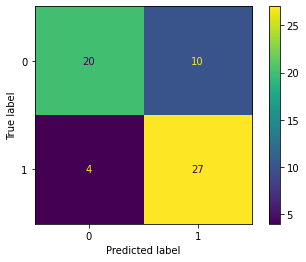

In [34]:
print_metrics(y_test, test_preds, scaled_X_test, y_train, train_preds)

## XGBoost:

In [1]:
#Need to turn X_train and X_test into a DMatrix
D_train = xgb.DMatrix(scaled_X_train, label=y_train)
D_test = xgb.DMatrix(scaled_X_test, label=y_test)

<IPython.core.display.Javascript object>

NameError: name 'scaled_X_train' is not defined

In [ ]:
clf = xgb.XGBClassifier()
parameters = {
    'eta': [0.005, 0.01, 0.02, 0.3],  
    'max_depth': [2, 3, 4, 5, 6],  
    'objective': ['multi:softprob', 'multi:softmax'],
    'num_class': [2, 3, 4, 5]} 

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="recall",
                    cv=5,
                    verbose=3)
#                     return_train_score=True)

grid.fit(X_train, y_train)